__Obiettivo__

Classificare i contenuti testuali, tra cui _Title_, _Abstract_ e _Introduction_, degli articoli in possesso tramite una lista predefinita di topic.

Il notebook implementa una __multi-label classification__ di un insieme di paper accademici in base ad una lista di _topic_ precedentemente stilata, riportata all'interno del path "_../markdown/topics.md_".
Per riuscire nell'intento, è stata attuata una fase preliminare di __preprocessing__, in cui le operazioni principali si suddividono in:
- Conversione del testo in minuscolo
- Suddivisione in _token_ del periodo analizzato
- Rimozione di numeri e punteggiatura ove necessario
- Rimozione delle _stopwords_, rese disponibili tramite la libreria __nltk__
- __Lemmatizzazione__ di ogni _token_ che costituisca il testo, ossia conversione del termine circoscritto nella sua forma canonica

Sfruttando modelli _LLM_ forniti da _OpenAI_, è stato sviluppato un _Agent Classificator_. Il compito dell'agente consiste nella definizione di una catalogazione iniziale dei contenuti testuali in possesso, affinchè sia delineato un _data set_ utile per istruire il modello di _Machine Learning_ scelto. Pertanto, la struttura del dataset realizzata è fondamentale per proseguire secondo un __apprendimento supervisionato__, data la presenza di variabili di _input_ e di _output_.

In [2]:
import os
import nltk

from nltk.corpus import stopwords

nltk.download("wordnet")
nltk.download("stopwords")
set_stopwords = set(stopwords.words("english"))

[nltk_data] Downloading package wordnet to /home/matte/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/matte/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from typing import Dict

class Paper:
    def __init__(self, title, abstract):
        self.title = title
        self.abstract = abstract 

    def get_dict(self) -> Dict[str, str]:
        return {
            "Title": self.title,
            "Abstract": self.abstract
        }

In [4]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate

load_dotenv()

class AgentClassificator:
    def __init__(self):
        system_message = """
            ### Goal
            You are an assistant responsible for classifying sections of scientific papers into specific labels.

            ### Assignments
            1. **Classification Rules**:
            - Classify each paper using only the labels listed below.
            - Each paper can be classified under **one or more labels**.
            - Only use the provided labels; any classification outside this list is not acceptable.

            3. **Input Format**:
            The input will be provided as a list in the following format:  
            ["Paper's title", "Paper's sections"]  

            4. **Output Requirements**:
            - Output should be a single string.
            - For each paper, list the title followed by the corresponding labels.
            - Separate multiple labels with commas (,) and separate papers with semicolons (;).

            5. **Example Output**:
            - First paper's title: 1.1 Search Techniques, 2.2 Distributed Systems; Second paper's title: 3.2 Middlegame Play, 5.1 Competitive Play
        """

        prompt = ChatPromptTemplate(
            [
                ("system", system_message),
                ("human", "List of labels to use during the classifications. \n {labels}"),
                ("human", "Dictionary containing the titles and sections of all the articles. \n {sections}")
            ]
        )

        llm = ChatOpenAI(
            model="gpt-4o",
            api_key=os.getenv("OPENAI_KEY"),
            temperature=0
        )

        self.agent = prompt | llm

    def get_agent(self):
        return self.agent

In [5]:
import regex

from typing import List, Set

# Function used to extract labels from topics provided by markdown
def define_labels() -> Dict[str, Set[str]]:
    dict_labels: Dict[str, Set[str]] = {}

    with open("../markdown/topics.md", "r") as file:
        content = file.read()
        
    categories = regex.findall(r"### (\d+)\.", content)
    for category in categories:
        matches = regex.findall(r"{}\.[0-9]?(.*\w)".format(category), content)
        cleaned_matches = [match.strip().replace("*", "") for match in matches]

        _set = set()
        for match in cleaned_matches[1:]:
            _set.add(match)

        dict_labels[cleaned_matches[0]] = _set

    return dict_labels

labels = define_labels()

Il _preprocessing_ permette di migliorare la qualità delle sezioni di testo in possesso, tentando di ovviare ai tipici problemi che possano verificarsi qualora manipolati __dati non strutturati__. Pertanto, sono elencate le tre principali operazioni effettuate durante tale fase, suddivise in:
- __Casefolding__, conversione del testo in minuscolo
- __Stopwords__, definizione dell'insieme di parole prive di una propria importanza
- __Lemmatizzazione__, conversione di ogni parola che componga il periodo nel proprio _lemma_

In [6]:
import json

from pandas import DataFrame
from langdetect import detect
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from deep_translator import GoogleTranslator

def get_json() -> List[Dict]:
    with open("../json/grobid/summary.json", "r") as file:
        content = file.read()

    return json.loads(content)

lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r"[a-zA-Z]+")

def preprocess_field(field: str) -> List[str] | None:
    try:
        if detect(field) != "en":
            field = GoogleTranslator(source="auto", target="en").translate(text=field)

        # Converting field to lower case and remove numbers and dots
        text = field.lower()
        tokens = tokenizer.tokenize(text)

        # Removing words less than two characters and stopwords
        tokens = [token for token in tokens if len(token) > 2]
        tokens = [token for token in tokens if token not in set_stopwords]

        # Applying lemmatizer for each paper's word
        return [lemmatizer.lemmatize(token) for token in tokens]
    except Exception:
        return None

def define_papers_dict(_json: List[Dict]) -> Dict[str, Paper]:
    dict_papers: Dict[str, Paper] = {}

    for _dict in _json:
        for key, value in _dict.items():
            title = preprocess_field(value["Title"])
            abstract = preprocess_field(value["Abstract"])

            dict_papers[key] = Paper(title, abstract)

    return dict_papers

_json = get_json()
dict_papers = define_papers_dict(_json)

def define_papers_dataframe(_dict: Dict[str, Paper]) -> DataFrame:
    records = []

    for key, value in _dict.items():
        try:
            record = {
                "Name": regex.findall(r"([0-9][0-9].+?)\.", key)[0],
                "Title": " ".join(value.title),
                "Abstract": " ".join(value.abstract) 
            }
 
            records.append(record)
        except Exception:
            continue
    
    return DataFrame(records)

df_papers = define_papers_dataframe(dict_papers)
df_papers["Text"] = df_papers["Title"] + " " + df_papers["Abstract"]

Il campo _Text_ è realizzato dall'unione di _Title_ e _Abstract_ di ogni articolo analizzato; il field circoscritto sarà poi successivamente dato in input all'agente classificatore, poichè componente essenziale del _system message_ sviluppato.

In [7]:
display(df_papers.head(5))

,Name,Title,Abstract,Text
0,00Aburaya,evolution gpagents chess knowledge integration...,project group also worked robocup soccer playi...,evolution gpagents chess knowledge integration...
1,00AlissandrakisNehanivDeutenhan,learning thing imitation,paper discus agent learn thing imitating agent...,learning thing imitation paper discus agent le...
2,00BaenaBelmonteMandow,intelligent tutor web based chess course,web based intelligent tutoring system try fill...,intelligent tutor web based chess course web b...
3,00BaxterTridgellWeaver b,learning play chess using temporal difference,paper present tdleaf variation algorithm enabl...,learning play chess using temporal difference ...
4,00BaxterTridgellWeaver,learning play chess using temporal difference,paper present tdleaf variation algorithm enabl...,learning play chess using temporal difference ...


Il _preprocessing_, oltre a migliorare la qualità dei _dati non strutturati_ in possesso, ha permesso al modello _LLM_ scelto una migliore classificazione; infatti, la rimozione di ambiguità lessicali e l'introduzione di alcuni accorgimenti tecnici, come la _lemmatizzazione_, ha garantito una maggiore efficacia di catalogazione.

In [8]:
def define_abstracts(df: DataFrame) -> Dict[str, str]:
    _dict: Dict[str, str] = {}

    for index, row in df.iterrows():
        _dict[row["Name"]] = row["Abstract"]

    return _dict

abstracts = define_abstracts(df_papers)

agent_classificator = AgentClassificator().get_agent()
response = agent_classificator.invoke({"labels": labels, "sections": abstracts}).content

In [9]:
# Function used to manually classify papers based on the received LLM response
def search_main_topic(topics_detected: List[str], labels: Dict[str, Set[str]]) -> Set[str]:
    main_topics: Set[str] = set()

    for topic_detected in topics_detected:
        for key, value in labels.items():
            if topic_detected in value:
                main_topics.add(key)

    return main_topics

def extract_classification_from_llm(response: str, labels: Dict[str, Set[str]]) -> Dict[str, List[str]]:
    _dict: Dict[str, List[str]] = {}

    lines = response.split(";")
    for line in lines:
        items = line.split(":")

        # Items contains the paper name at [0] and the topics assigned to the paper at [1]
        paper_name = items[0].strip()
        topics_detected = [topic.strip() for topic in items[1].split(",")]
    
        main_topics = search_main_topic(topics_detected, labels)
        _dict[paper_name] = list(main_topics)
        
    return _dict

dict_initial_classifications = extract_classification_from_llm(response, labels)

def define_initial_dataframe(labels: Dict[str, Set[str]], _dict: Dict[str, List[str]], df_papers: DataFrame) -> DataFrame:
    _df = df_papers.drop(columns=["Title", "Abstract"])

    for label in labels.keys():
        _df[label] = 0 

    for key, value in _dict.items():
        _df.loc[_df["Name"] == key, value] = 1

    return _df

df_initial = define_initial_dataframe(labels, dict_initial_classifications, df_papers)

Tramite lo snippet di codice seguente, sono visualizzate le prime cinque _row_ del _data frame_ successivo alla classificazione realizzata dall'agente. La catalogazione è piuttosto sbilanciata, alcune _etichette_ sono attribuite con maggiore preponderanza rispetto ad altre. Ciò potrebbe diminuire drasticamente lo _score_ del modello di _Machine Learning_, data la mancanza di un equilibrio dei dati.

In [10]:
display(df_initial.head(5))

,Name,Text,Algorithmic Approaches,Architectural Designs,Game Stages,Training and Evaluation,Applications,Ethical and Practical Concerns
0,00Aburaya,evolution gpagents chess knowledge integration...,1,0,0,0,0,0
1,00AlissandrakisNehanivDeutenhan,learning thing imitation paper discus agent le...,0,0,0,0,1,0
2,00BaenaBelmonteMandow,intelligent tutor web based chess course web b...,0,0,0,1,1,0
3,00BaxterTridgellWeaver b,learning play chess using temporal difference ...,1,0,0,0,1,0
4,00BaxterTridgellWeaver,learning play chess using temporal difference ...,1,0,0,0,1,0


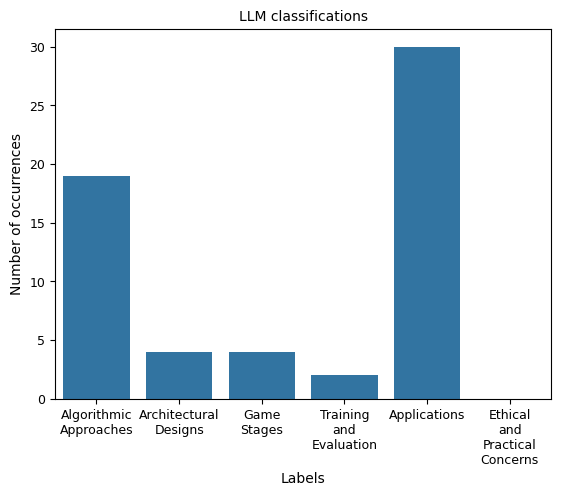

In [29]:
import seaborn
import matplotlib.pyplot as plt

x = df_initial.iloc[:, 2:8].sum()
x_labels = [item.replace(" ", "\n") for item in x.index]

plt.title("LLM classifications", fontsize=10)

ax = seaborn.barplot(x=x_labels, y=x.values)

plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

plt.xlabel("Labels", fontsize=10)
plt.ylabel("Number of occurrences", fontsize=10)

plt.show()

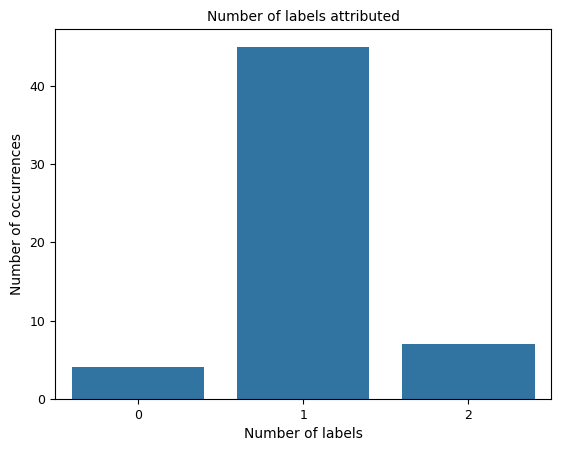

In [ ]:
_dict: Dict[str, int] = {}
for index, row in df_initial.iterrows():
    sum_topics = str(row.iloc[2:7].sum())

    if sum_topics in _dict:
        _dict[sum_topics] += 1
    else:
        _dict[sum_topics] = 1

_dict = dict(sorted(_dict.items()))

plt.title("Number of labels attributed", fontsize=10)

ax = seaborn.barplot(x=_dict.keys(), y=_dict.values())

plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

plt.xlabel("Number of labels", fontsize=10)
plt.ylabel("Number of occurrences", fontsize=10)

plt.show()

In [13]:
import numpy

from sklearn.model_selection import train_test_split

# Input and output variables
x = df_initial["Text"]
y = numpy.asarray(df_initial[df_initial.columns[2:]])

# Split the data set between train set and test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=None)

La tecnica __TF-IDF__ permette di convertire le _parole_ appartenenti ad un contenuto testuale in _valori numerici_ che ne denotano la loro importanza. La conversione dei contenuti testuali in formati numerici rappresenta un passaggio fondamentale per attuare algoritmi di classificazione, dato che modelli di _Machine Learning_ non sono in grado di analizzare direttamente le paroli testuali; pertanto, è necessaria una rappresentazione delle stesse in un formato consono.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import TfidfVectorizer